Note: for Jarvis Labs need to install the following packages:
* pygame - `pip install -U pygame --user`

# Deep Reinforcment Learning for Snake Game

We want to train an agent to play Snake. The Snake starts as 3 squares long and has to move around a constrained space and eat rats. One rat appears randomly at a time. If the snake crashes into its own body or the walls, it dies. If it eats a rat, it scores a point and grows one square longer. 

We aim to train our agent to score highly in the game.

We used several different approaches. Firstly, the way that the snake perceives it's environment might make a difference.

The `get_observation` method of Agent class gives a ndarray (converted to tensor) representing the snakes perceived environment. We designed three versions. All are flat arrays with values of 0 or 1 representing False and True. All have 4 entries which represent whether the rat is ahead, behind, left or right of the snake (relative to the direction the snake is facing).
* Simple. ndarry of shape (11,). 3 values representing if there is a fatal collision directly infront-of, left or right of the snakes head. 4 values to represent if the snake is facing up, down, left or right. 4 values representing relative position of rat.
* Surroundings. ndarray of shape (29,). 25 values representing the squares in the 5x5 area around the snakes head: relative to the direction the snake is facing. Values are 1 if square is occupied by the snake's body or a wall, 0 otherwise. 4 values representing relative position of the rat.
* Relative_Snake. ndarray of shape (12,). The first four values indicate whether any portion of the snake's body is ahead, behind, left of right from where the snake is facing. The hope is that it learns to steer away from it's own body to avoid collisions. The next four values represent an immediate collision ahead, behind, left or right of the snake. The last four values represent the relative position of the rat.

In addition to this we have several approaches to learning the optimum policy:
* Deep Q-Learning
* Double Deep Q-Learning
* Dueling Networks.

Finally, with no real adjustment to the code, our representation of the environment is conjucive to curriculum learning: we can train the agent on smaller (easier) environments and then test it - even on zero shot basis - against the full size environment.

In [1]:
from Game import SnakeGameAI
from helper import training_loop, plot, ax_plot
from collections import namedtuple
from IPython import display
from matplotlib import pyplot as plt
import numpy as np

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


Set some global variables we will use for most games:

In [2]:
UI = False # set this to True if you want to see the snake eating the rats. Highly recommended!
TRAINING_EPISODES = 1500
EVALUATION_EPISODES = 30
DQN_Style = {'DQN': {'double_dqn': False, 'dueling_dqn': False},
             'Double_DQN': {'double_dqn': True, 'dueling_dqn': False},
             'Dueling_DQN': {'double_dqn': False, 'dueling_dqn': True},
             'Double_Dueling_DQN': {'double_dqn': True, 'dueling_dqn': True}}
Output = namedtuple('Output', ['agent', 'scores', 'mean_scores'])

Charts below just help us calibrate epsilon greedy parameters. We have hardcoded the epsilon floor of 0.05. Starting epsilon and epsilon decay for epsilon > or < 0.5 can be set. Epsilon is updated after each episode. We choose epsilon to decay from a high number to a low number over the course of training. The 200 and 250 episode cases are for curriculum learning, where the model has already been trained a bit, so epsilon starts lower.

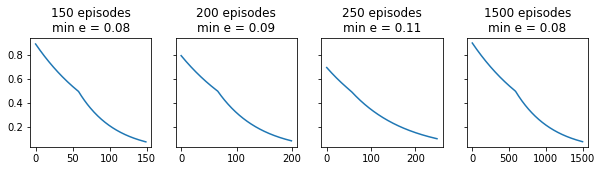

In [3]:
def epsilon_decay(steps, e, e_decay, min_e=0.05):
    a = np.ones(steps) * e_decay[0]
    b = np.ones(steps) * e_decay[1]
    aa = np.cumproduct(a) * e
    bb = np.cumproduct(b) * e
    thresh_idx = np.argmax(aa < 0.5)
    eps = np.where(aa > 0.5, aa,
                   aa[thresh_idx] / bb[thresh_idx] * bb)
    eps = np.where(eps > min_e, eps, min_e)
    return eps

fig, axs = plt.subplots(1,4,sharey=True, figsize=(10,2))

eps_list = []
eps_list.append(epsilon_decay(150, 0.9, [0.99, 0.98]))
eps_list.append(epsilon_decay(200, 0.8, [0.993, 0.987]))
eps_list.append(epsilon_decay(250, 0.7, [0.994, 0.992]))
eps_list.append(epsilon_decay(1500, 0.9, [0.999, 0.998]))
steps_list = [150, 200, 250, 1500]

for i, ax in enumerate(axs.flatten()):
    ax.plot(eps_list[i])
    ax.set_title("{} episodes\nmin e = {:.2f}"
                 .format(steps_list[i], eps_list[i][-1]))
                 
plt.show()

## Different approaches to observed environment

With the basic DQN approach, we can see which representation of the environment looks most promising. We will train the snake for 1000 episodes for each representation and then evaluate over 20 episodes using the optimum learned policy. 

We will use this representation of the environment for comparison of different learning algorithms.

### 1. get_observation_simple

First train the model:

In [4]:
MODEL_NAME = '_simple.pth'
SAVE_NAME = '_simple_best.pth'
GET_OBS='simple'
simple_output_dict = {}

In [5]:
for key, val in DQN_Style.items():
    game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                    'window_title': "{} - {}".format(key, GET_OBS)}

    agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                               model_name=key + MODEL_NAME,
                                               load_model=False,
                                               save_name=key + SAVE_NAME,
                                               episode_save = 350,
                                               get_observation=GET_OBS,
                                               greedy=True,
                                               **val, # dict for kwargs
                                               num_episodes=TRAINING_EPISODES,
                                               plot_update_at_end=True
                                              )
    agent.save_model(key + MODEL_NAME)
    simple_output_dict[key] = Output(agent, scores, mean_scores)

display.clear_output()

### 2. get_observation_surroundings

First train the model:

In [6]:
MODEL_NAME = '_surroundings.pth'
SAVE_NAME = '_surroundings_best.pth'
GET_OBS='surroundings'
surroundings_output_dict = {}

In [7]:
for key, val in DQN_Style.items():
    game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                    'window_title': "{} - {}".format(key, GET_OBS)}

    agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                               model_name=key + MODEL_NAME,
                                               load_model=False,
                                               save_name=key + SAVE_NAME,
                                               episode_save = 350,
                                               get_observation=GET_OBS,
                                               greedy=True,
                                               **val, # dict for kwargs
                                               num_episodes=TRAINING_EPISODES,
                                               plot_update_at_end=True
                                              )
    agent.save_model(key + MODEL_NAME)
    surroundings_output_dict[key] = Output(agent, scores, mean_scores)

display.clear_output()

### 3. get_observation_relative_snake

First train the model:

In [8]:
MODEL_NAME = '_relative.pth'
SAVE_NAME = '_relative_best.pth'
GET_OBS='relative_snake'
relative_output_dict = {}

In [9]:
for key, val in DQN_Style.items():
    game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                    'window_title': "{} - {}".format(key, GET_OBS)}

    agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                               model_name=key + MODEL_NAME,
                                               load_model=False,
                                               save_name=key + SAVE_NAME,
                                               episode_save = 350,
                                               get_observation=GET_OBS,
                                               greedy=True,
                                               **val, # dict for kwargs
                                               num_episodes=TRAINING_EPISODES,
                                               plot_update_at_end=True
                                              )
    agent.save_model(key + MODEL_NAME)
    relative_output_dict[key] = Output(agent, scores, mean_scores)

display.clear_output()

### Display results of training

Score of individual episodes in blue, moving average in green, average for episodes plays so far in orange.

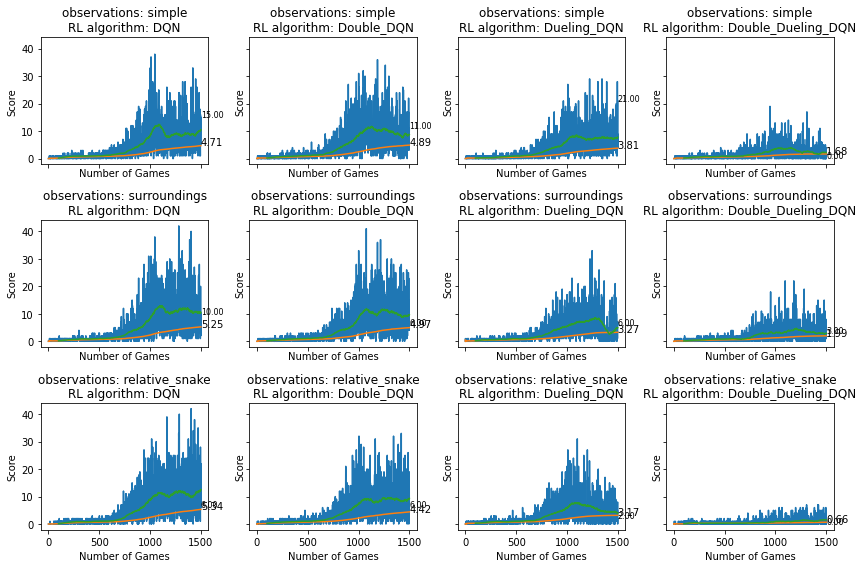

In [10]:
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))
outputs = {'simple': simple_output_dict,
          'surroundings': surroundings_output_dict,
          'relative_snake': relative_output_dict}

output_list = []
for out_key, out_val in outputs.items():
    for key, val in out_val.items():
        output_list.append(['observations: {}\nRL algorithm: {}'.format(out_key, key),
                            val.scores, val.mean_scores, val.agent.epsilon])

for i, ax in enumerate(axs.flatten()):
    ax_plot(ax, output_list[i][1], output_list[i][2], title=output_list[i][0])
fig.tight_layout()

### Evaluation of algorithm performance

We run 20 episodes of each algorithm and observation combination, with each making the optimal policy choice (no randomness).

We se same random seed for each game so that evaluations are comparible.

Example of a game being played at evaluation stage:

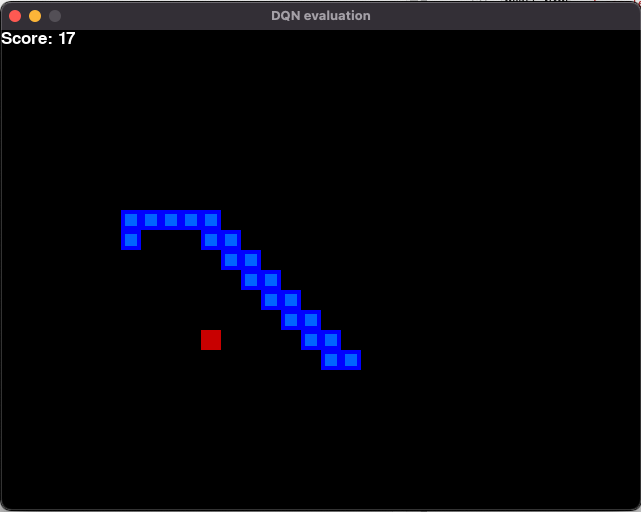

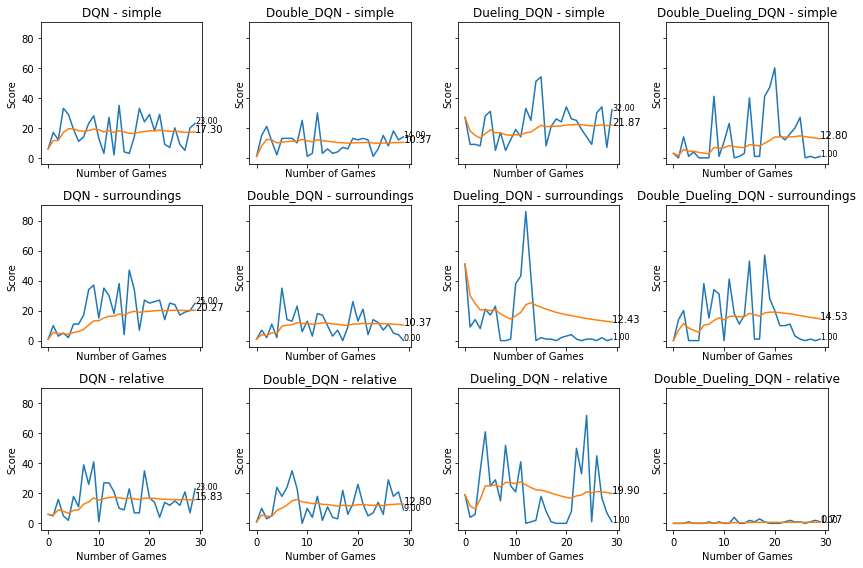

In [11]:
eval_dict = {}
for out_key in ['simple', 'surroundings', 'relative']:
    for key, val in DQN_Style.items():
        game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                       'window_title': "{} - {}".format(key, out_key)
                      }
        agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                                   model_name='{}_{}.pth'.format(key, out_key),
                                                   load_model=True,
                                                   get_observation=out_key,
                                                   greedy=False,
                                                   **val, # dict for kwargs
                                                   num_episodes=EVALUATION_EPISODES,
                                                   plot_update_at_end=True,
                                                   random_seed=1
                                                  )
        eval_dict["{} - {}".format(key, out_key)] = Output(agent, scores, mean_scores)
        
display.clear_output(wait=True)
        
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))

for i, ax in enumerate(axs.flatten()):
    scores = list(eval_dict.values())[i].scores
    mean_scores = list(eval_dict.values())[i].mean_scores
    title = list(eval_dict.keys())[i]
    
    ax_plot(ax, scores, mean_scores, window=None, title=title)
    
fig.tight_layout()

### Evaluating on best parameters not final parameters

As well as saving the models after 1500 iterations, we also recorded the moving average score of the last 100 episodes. We saved model parameters for each agent at the maximum of this moving average. Many models exhibit deteriorating performance later on in training, so we want to pick when the model was at its best: greedy results have noise, but picking the max moving average is a good guess at best parameter set.

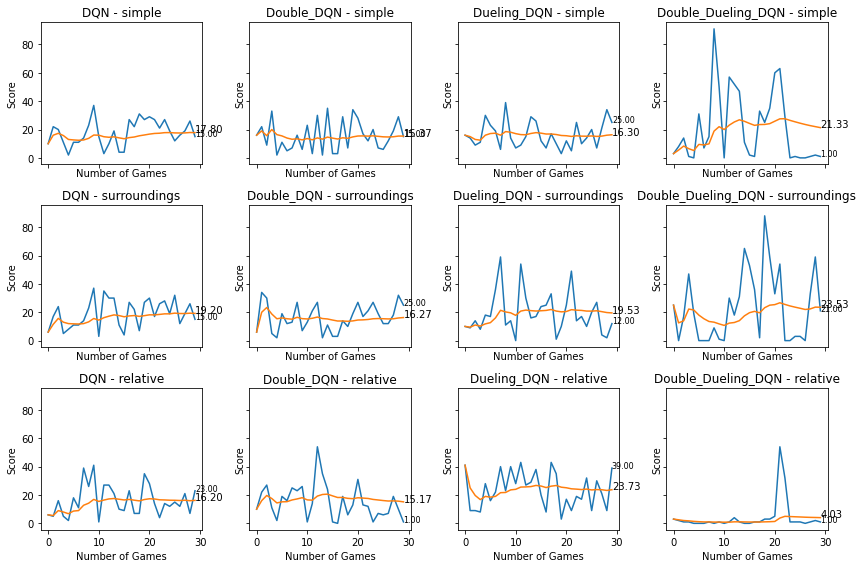

In [20]:
eval_dict = {}
for out_key in ['simple', 'surroundings', 'relative']:
    for key, val in DQN_Style.items():
        game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                       'window_title': "{} - {}".format(key, out_key)
                      }
        agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                                   model_name='{}_{}_best.pth'.format(key, out_key),
                                                   load_model=True,
                                                   get_observation=out_key,
                                                   greedy=False,
                                                   **val, # dict for kwargs
                                                   num_episodes=EVALUATION_EPISODES,
                                                   plot_update_at_end=True,
                                                   random_seed=1
                                                  )
        eval_dict["{} - {}".format(key, out_key)] = Output(agent, scores, mean_scores)
        
display.clear_output(wait=True)
        
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))

for i, ax in enumerate(axs.flatten()):
    scores = list(eval_dict.values())[i].scores
    mean_scores = list(eval_dict.values())[i].mean_scores
    title = list(eval_dict.keys())[i]
    
    ax_plot(ax, scores, mean_scores, window=None, title=title)
    
fig.tight_layout()

### Evaluating on 350 training episodes

The base curriculum learning regime trains on 350 episodes (150 on small grid and 200 on medium grid) before going for a zero-shot evaluation on the full sized grid.

To compare performance vs same amound of training on the full sized grid, we retrieve trained weights after 350 episodes for each of the algorithms, and evaluate performance of these.

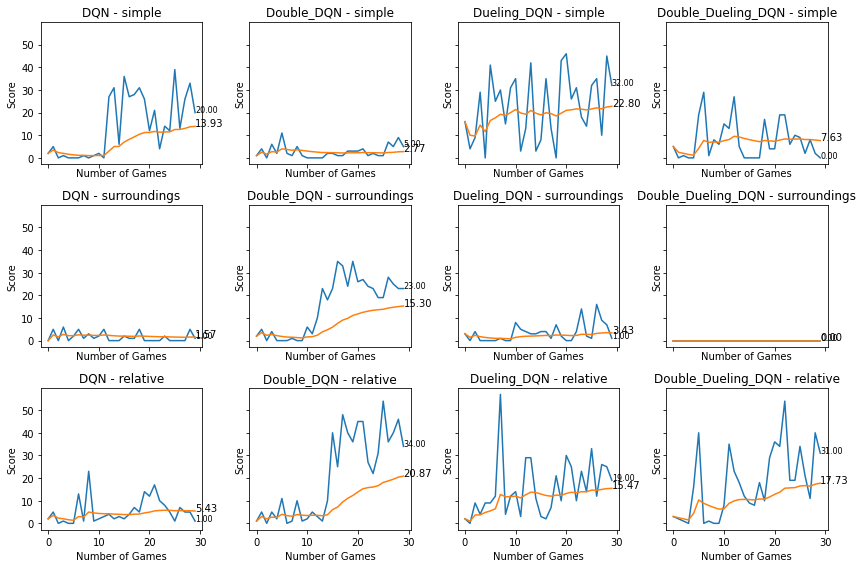

In [22]:
eval_dict = {}
for out_key in ['simple', 'surroundings', 'relative']:
    for key, val in DQN_Style.items():
        game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                       'window_title': "{} - {}".format(key, out_key)
                      }
        agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                                   model_name='{}_{}_best_350_episodes.pth'.format(key, out_key),
                                                   load_model=True,
                                                   get_observation=out_key,
                                                   greedy=False,
                                                   **val, # dict for kwargs
                                                   num_episodes=EVALUATION_EPISODES,
                                                   plot_update_at_end=True,
                                                   random_seed=1
                                                  )
        eval_dict["{} - {}".format(key, out_key)] = Output(agent, scores, mean_scores)
        
display.clear_output(wait=True)
        
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))

for i, ax in enumerate(axs.flatten()):
    scores = list(eval_dict.values())[i].scores
    mean_scores = list(eval_dict.values())[i].mean_scores
    title = list(eval_dict.keys())[i]
    
    ax_plot(ax, scores, mean_scores, window=None, title=title)
    
fig.tight_layout()

## Curriculum Learning

### First stage

First we train the agent on a really small grid - equivalent to 6 x 6 blocks.

The intuition is that the snake will spend more time learning to avoid walls, and also be more likley to randomly eat a rat and discover that it's worth finding the rat when the grid is smaller.

### Second stage

Now we train the agent on a slightly larger grid: 10 x 10 blocks.

The grid is large enough the the snake's observation field (5 x 5 blocks surrounding snakes head) is always missing quite a bit of information about the full environment. The snake should train to factor in the relative lack of information.

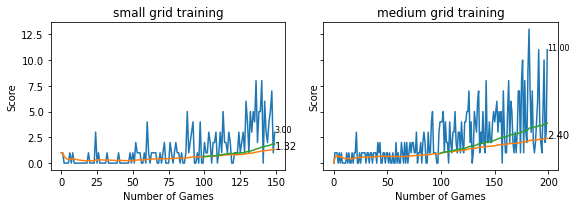

In [12]:
UI = False
TRAINING_EPISODES = 150
EVAL_EPISODES = 30
GET_OBS = 'surroundings'
DOUBLE_DQN = False
DUELING_DQN = True
MODEL_NAME = 'small_grid.pth'
EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.99, 0.98]}
curriculum_output = {}

game_kwargs = {'width': 120, 'height': 120, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=MODEL_NAME,
                                           load_model=False,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(MODEL_NAME)
curriculum_output[MODEL_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

################
# SECOND STAGE:
################


TRAINING_EPISODES = 200
LOAD_NAME = 'small_grid.pth'
SAVE_NAME = 'medium_grid.pth'
EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 200, 'height': 200, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

display.clear_output()

keys = list(curriculum_output.keys())
titles = ['small grid training', 'medium grid training']
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 3))

for i, ax in enumerate(axs.flatten()):
    ax_plot(ax, curriculum_output[keys[i]].scores,
            curriculum_output[keys[i]].mean_scores,
            title=titles[i])
fig.tight_layout()
plt.show()

### Zero shot

Evaluate the model trained so far on the full-sized grid. How does it compete with the other agents that have trained for 1500 episodes on the full-sized grid?

It does! The agent outperforms all previous agents despite having only trained for 300 episodes on very simple problems.

<Figure size 432x288 with 0 Axes>

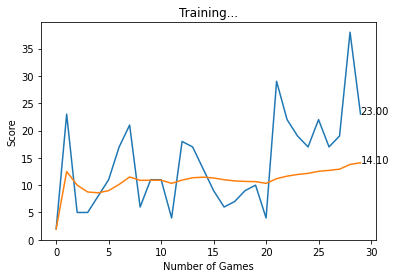

In [13]:
# using new obserations
LOAD_NAME = 'medium_grid.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

zero_shot_output = Output(agent, scores, mean_scores)

### Third round: train on full-sized grid, epsilon starts at 0.7

<Figure size 432x288 with 0 Axes>

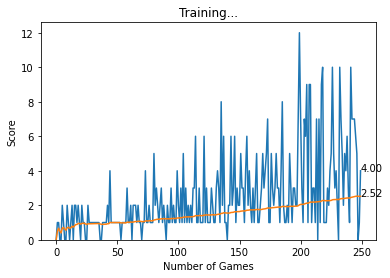

In [14]:
TRAINING_EPISODES = 250
LOAD_NAME = 'medium_grid.pth'
SAVE_NAME = 'full_gridv2.pth'
EPS_KW = {'epsilon': 0.7, 'epsilon_decay':[0.994, 0.992]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

### Evaluate: full-sized grid, third round, epsilon = 0.7

<Figure size 432x288 with 0 Axes>

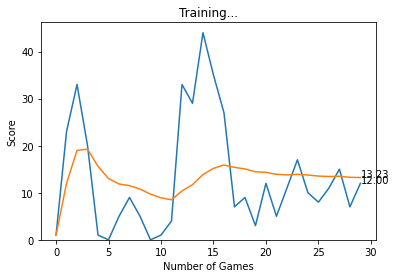

In [15]:
# using new obserations
LOAD_NAME = 'full_gridv2.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

eval_output = Output(agent, scores, mean_scores)


### Try third round on "medium-plus" grid

The jump from a 10x10 to a 32x24 grid is quite big. What happens if we train on a 20x16 grid as a third round and then evaluate on zero shot or fourth round of training on full-sized grid?

<Figure size 432x288 with 0 Axes>

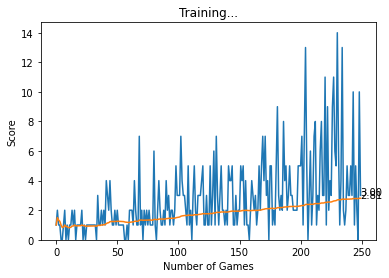

In [16]:
TRAINING_EPISODES = 250
LOAD_NAME = 'medium_grid.pth'
SAVE_NAME = 'medium_plus_grid.pth'
EPS_KW = {'epsilon': 0.7, 'epsilon_decay':[0.994, 0.992]}

game_kwargs = {'width': 400, 'height': 320, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

### Zero shot evaluation after 3 rounds of curriculum training

<Figure size 432x288 with 0 Axes>

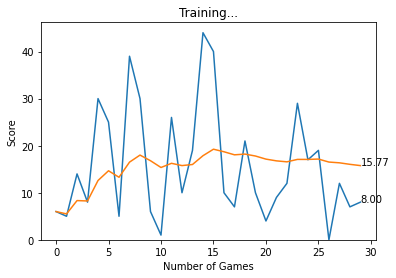

In [17]:
# using new obserations
LOAD_NAME = 'medium_plus_grid.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

eval_output = Output(agent, scores, mean_scores)


### 4th round of training - full-sized grid, epsilon = 0.7

This agent has trainded on 6x6, 10x10, 10x16 and finall on 32x24.

<Figure size 432x288 with 0 Axes>

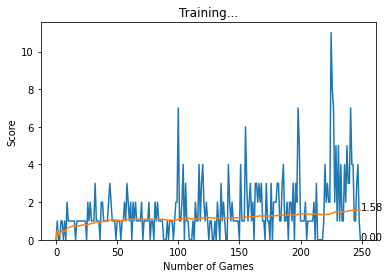

In [18]:
TRAINING_EPISODES = 250
LOAD_NAME = 'medium_plus_grid.pth'
SAVE_NAME = 'full_gridv3.pth'
EPS_KW = {'epsilon': 0.7, 'epsilon_decay':[0.994, 0.992]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

### Evaluate after 4 training rounds

<Figure size 432x288 with 0 Axes>

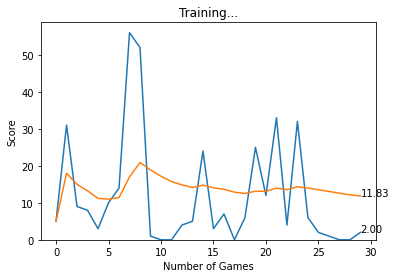

In [19]:
# using new obserations
LOAD_NAME = 'full_gridv3.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

eval_output = Output(agent, scores, mean_scores)


## Curriculum Learning - do it all again with DQN (not DDQN)!

### First stage

First we train the agent on a really small grid - equivalent to 6 x 6 blocks.

The intuition is that the snake will spend more time learning to avoid walls, and also be more likley to randomly eat a rat and discover that it's worth finding the rat when the grid is smaller.

### Second stage

Now we train the agent on a slightly larger grid: 10 x 10 blocks.

The grid is large enough the the snake's observation field (5 x 5 blocks surrounding snakes head) is always missing quite a bit of information about the full environment. The snake should train to factor in the relative lack of information.

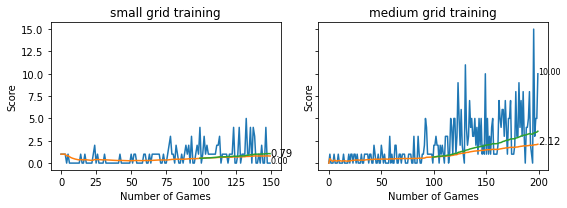

In [23]:
UI = False
TRAINING_EPISODES = 150
EVAL_EPISODES = 30
GET_OBS = 'surroundings'
DOUBLE_DQN = False
DUELING_DQN = False
MODEL_NAME = 'DQN_small_grid.pth'
EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.99, 0.98]}
curriculum_output = {}

game_kwargs = {'width': 120, 'height': 120, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=MODEL_NAME,
                                           load_model=False,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(MODEL_NAME)
curriculum_output[MODEL_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

################
# SECOND STAGE:
################


TRAINING_EPISODES = 200
LOAD_NAME = 'DQN_small_grid.pth'
SAVE_NAME = 'DQN_medium_grid.pth'
EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 200, 'height': 200, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

display.clear_output()

keys = list(curriculum_output.keys())
titles = ['small grid training', 'medium grid training']
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 3))

for i, ax in enumerate(axs.flatten()):
    ax_plot(ax, curriculum_output[keys[i]].scores,
            curriculum_output[keys[i]].mean_scores,
            title=titles[i])
fig.tight_layout()
plt.show()

### Zero shot

Evaluate the model trained so far on the full-sized grid. How does it compete with the other agents that have trained for 1500 episodes on the full-sized grid?

It does! The agent outperforms all previous agents despite having only trained for 300 episodes on very simple problems.

<Figure size 432x288 with 0 Axes>

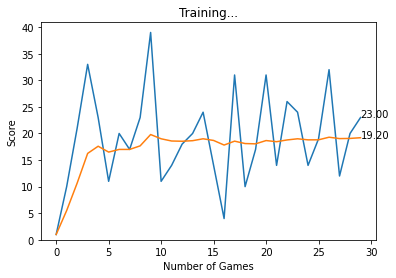

In [24]:
# using new obserations
LOAD_NAME = 'DQN_medium_grid.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

zero_shot_output = Output(agent, scores, mean_scores)

### Third round: train on full-sized grid, epsilon starts at 0.7

<Figure size 432x288 with 0 Axes>

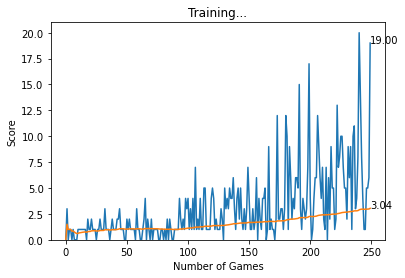

In [25]:
TRAINING_EPISODES = 250
LOAD_NAME = 'DQN_medium_grid.pth'
SAVE_NAME = 'DQN_full_gridv2.pth'
EPS_KW = {'epsilon': 0.7, 'epsilon_decay':[0.994, 0.992]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

### Evaluate: full-sized grid, third round, epsilon = 0.7

<Figure size 432x288 with 0 Axes>

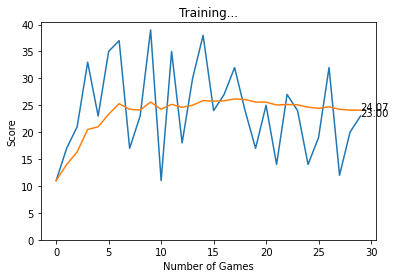

In [26]:
# using new obserations
LOAD_NAME = 'DQN_full_gridv2.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

eval_output = Output(agent, scores, mean_scores)


### Try third round on "medium-plus" grid

The jump from a 10x10 to a 32x24 grid is quite big. What happens if we train on a 20x16 grid as a third round and then evaluate on zero shot or fourth round of training on full-sized grid?

<Figure size 432x288 with 0 Axes>

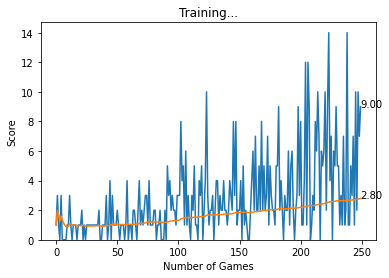

In [28]:
TRAINING_EPISODES = 250
LOAD_NAME = 'DQN_medium_grid.pth'
SAVE_NAME = 'DQN_medium_plus_grid.pth'
EPS_KW = {'epsilon': 0.7, 'epsilon_decay':[0.994, 0.992]}

game_kwargs = {'width': 400, 'height': 320, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

### Zero shot evaluation after 3 rounds of curriculum training

<Figure size 432x288 with 0 Axes>

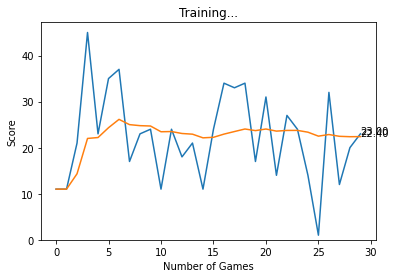

In [29]:
# using new obserations
LOAD_NAME = 'DQN_medium_plus_grid.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

eval_output = Output(agent, scores, mean_scores)


### 4th round of training - full-sized grid, epsilon = 0.7

This agent has trainded on 6x6, 10x10, 10x16 and finall on 32x24.

<Figure size 432x288 with 0 Axes>

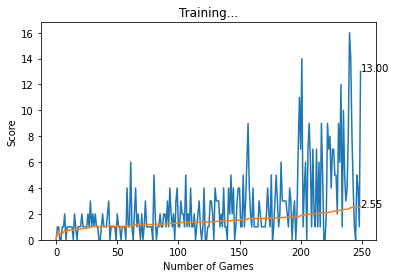

In [30]:
TRAINING_EPISODES = 250
LOAD_NAME = 'DQN_medium_plus_grid.pth'
SAVE_NAME = 'DQN_full_gridv3.pth'
EPS_KW = {'epsilon': 0.7, 'epsilon_decay':[0.994, 0.992]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

### Evaluate after 4 training rounds

<Figure size 432x288 with 0 Axes>

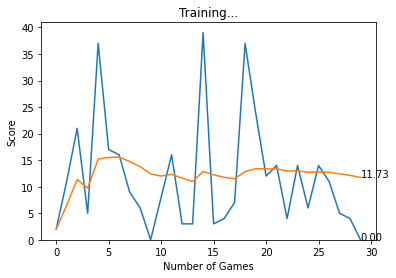

In [31]:
# using new obserations
LOAD_NAME = 'DQN_full_gridv3.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

eval_output = Output(agent, scores, mean_scores)


### 

### 